# DV analysis for TFs

In [13]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [14]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [15]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'

In [16]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [17]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read 1d HT result comparing to control

In [6]:
cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [7]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}_20200320.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [8]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

In [9]:
ciliated_beta = all_result['ciliated']['ht']['beta']['6']
ciliated_gamma = all_result['ciliated']['ht']['gamma']['6']
ciliated_lambda = all_result['ciliated']['ht']['lambda']['6']

In [10]:
print('Number of DE genes', ciliated_beta.query('de_fdr < 0.01').shape[0])
print('Number of DV genes', ciliated_beta.query('dv_fdr < 0.1').shape[0])

Number of DE genes 3776
Number of DV genes 761


### TFs

In [39]:
tf_df = pd.read_csv('../DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tf_df = tf_df[tf_df['Is a GO TF?'] == 'Yes']

all_tfs = tf_df['HGNC symbol'].tolist()

In [40]:
encode_tfs = pd.read_csv('../figure_5/encode_tfs.txt', sep='\t').gene.tolist()

In [41]:
filtered_tfs = list(set(encode_tfs)&set(all_tfs))

In [42]:
# filtered_tfs = """MAFG
# SPI1
# ZNF655
# MAX
# ATF4
# ATF3
# IRF2
# IRF1
# ARID5A
# BACH1
# YY1
# HMGA1
# IRF7
# STAT1
# NR1H2
# XBP1
# ETV6
# MSC
# ATF5
# MAFB
# FOS
# CEBPB
# BBX
# STAT3
# REL
# JUN
# CEBPD
# DDIT3
# NR3C1
# TGIF1
# ZNF267
# NFE2L2
# HIF1A
# AHR
# GTF2B
# CREM
# HBP1
# RELB
# TFEC
# YBX1
# ELF1
# JUNB
# NFKB1
# IRF9
# RBPJ
# KLF6""".split()

### Variabilities of TFs

In [50]:
len(filtered_tfs)

93

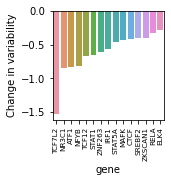

In [53]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'7.2',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

plt.figure(figsize=(2,2))
dat = ciliated_gamma.query('gene in @filtered_tfs & dv_coef < 0').sort_values('dv_coef').head(15)
sns.barplot(x='gene', y='dv_coef', data=dat)
plt.xticks(rotation=90);
plt.ylabel('Change in variability')

plt.savefig(fig_path + 'tf_var_barplot_ifng.pdf', bbox_inches='tight')


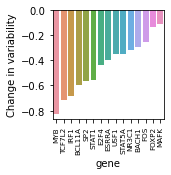

In [54]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'7.2',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

plt.figure(figsize=(2,2))
dat = ciliated_beta.query('gene in @filtered_tfs & dv_coef < 0').sort_values('dv_coef').head(15)
sns.barplot(x='gene', y='dv_coef', data=dat)
plt.xticks(rotation=90);
plt.ylabel('Change in variability')

plt.savefig(fig_path + 'tf_var_barplot.pdf', bbox_inches='tight')


### DE vs DV scatter plot

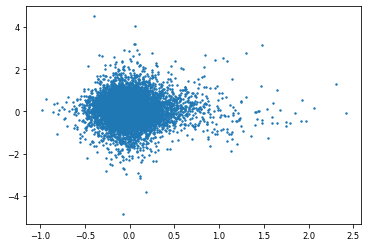

In [12]:
plt.scatter(ciliated_gamma['de_coef'], ciliated_gamma['dv_coef'], s=2)

In [59]:
isgs = ['IFIT1', 'ISG15', 'IFIT2', 'IFIT3', 'STAT1', 'STAT2', 'IRF1']

In [60]:
ciliated_gamma.query('gene in @isgs')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3,ISG15,1.017541,0.077430,9.827793e-06,-1.492312,0.291195,0.000273,0.000701,0.076611
1432,STAT1,1.387743,0.044482,6.359643e-07,-1.189647,0.228702,0.000604,0.000216,0.116611
2818,IRF1,1.683663,0.053392,8.842507e-07,-0.600169,0.414129,0.203080,0.000220,0.938962
4878,IFIT2,0.754981,0.146770,4.761746e-05,-0.654494,0.362706,0.075992,0.001360,0.938962
4879,IFIT3,1.104023,0.083473,4.171446e-05,-1.298813,0.298092,0.000160,0.001281,0.068756
4880,IFIT1,0.463611,0.082514,1.281600e-04,-0.145942,0.448213,0.718928,0.002252,0.978451
5831,STAT2,1.024607,0.068007,5.600529e-06,-0.371358,0.359609,0.292971,0.000576,0.943492


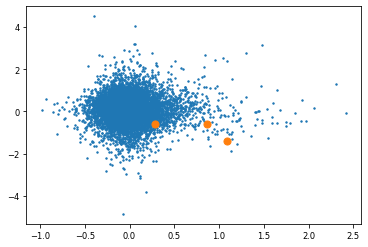

In [47]:
plt.scatter(ciliated_gamma['de_coef'], ciliated_gamma['dv_coef'], s=2)
plt.scatter(
    ciliated_gamma.query('gene in @isgs')['de_coef'], 
    ciliated_gamma.query('gene in @isgs')['dv_coef'], s=50)

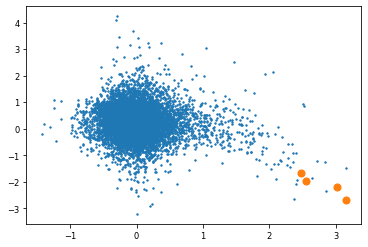

In [45]:
plt.scatter(ciliated_beta['de_coef'], ciliated_beta['dv_coef'], s=2)
plt.scatter(
    ciliated_beta.query('gene in @isgs')['de_coef'], 
    ciliated_beta.query('gene in @isgs')['dv_coef'], s=50)

### Get genes that are likely ISGF3 binding

In [107]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [108]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF747ICD/@@download/ENCFF747ICD.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])
stat2_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF204VQS/@@download/ENCFF204VQS.bed.gz',
    'https://www.encodeproject.org/files/ENCFF545JVD/@@download/ENCFF545JVD.bed.gz'
])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python

In [109]:
intersect_bed = stat1_bed.intersect(stat2_bed).sort()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [110]:
isgf3_genes = enc.get_peak_genes_bed(intersect_bed, 0).query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pybedtools/bedtool.py:3678: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file 

### Get genes that are likely GAF binding

In [111]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF431NLF/@@download/ENCFF431NLF.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [112]:
potential_gaf_genes = enc\
    .get_peak_genes_encode('https://www.encodeproject.org/files/ENCFF431NLF/@@download/ENCFF431NLF.bed.gz', 0)\
    .query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pybedtools/bedtool.py:3678: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file 

In [113]:
baseline_stat1_genes = enc\
    .get_peak_genes_encode('https://www.encodeproject.org/files/ENCFF323QQU/@@download/ENCFF323QQU.bed.gz', 0)\
    .query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pybedtools/bedtool.py:3678: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file 

In [114]:
gaf_genes =potential_gaf_genes #list(set(potential_gaf_genes) - set(baseline_stat1_genes))

In [115]:
len(gaf_genes)

934

In [116]:
len(isgf3_genes)

309

### DV coefficients for TSS/non-TSS genes

In [117]:
gamma_df = all_result['ciliated']['ht']['gamma']['6']
gamma_df['TSS'] = ['in TSS' if g in gaf_genes else 'rest' for g in gamma_df.gene.tolist() ]
gamma_df = gamma_df.query('de_coef > 0 & de_fdr < 0.05').copy()
gamma_df['stim'] = 'IFNG'

alpha_df = all_result['ciliated']['ht']['alpha']['6']
alpha_df['TSS'] = ['in TSS' if g in isgf3_genes else 'rest' for g in alpha_df.gene.tolist() ]
alpha_df = alpha_df.query('de_coef > 0 & de_fdr < 0.05').copy()
alpha_df['stim'] = 'IFNA'

beta_df = all_result['ciliated']['ht']['beta']['6']
beta_df['TSS'] = ['in TSS' if g in isgf3_genes else 'rest' for g in beta_df.gene.tolist() ]
beta_df = beta_df.query('de_coef > 0 & de_fdr < 0.05').copy()
beta_df['stim'] = 'IFNB'

stim_df = pd.concat([alpha_df, beta_df, gamma_df])

In [118]:
stats.mannwhitneyu(gamma_df.query('TSS == "in TSS"').dv_coef, gamma_df.query('TSS != "in TSS"').dv_coef)

MannwhitneyuResult(statistic=23654.0, pvalue=0.003198072859705311)

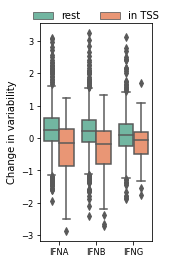

In [123]:
plt.figure(figsize=(2,4))
sns.boxplot(x='stim', y='dv_coef', hue='TSS', data=stim_df, palette='Set2')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1), frameon=False)
plt.xlabel(None); plt.ylabel('Change in variability');
plt.savefig(fig_path + 'dv_tss.pdf', bbox_inches='tight')
